doplnit graf zobrazujici data porizeni snimku

In [1]:
# import libraries
from sentinelsat import SentinelAPI
import geopandas as gpd
import matplotlib.pyplot as plt

from os import listdir
from os.path import join

In [2]:
ROOT_DIR = '/media/sf_JD/DP'

In [3]:
# read credentials from file
def read_credentials(filename):
    with open(filename, 'r') as txtfile:
        username, password = txtfile.read().split()
        return username, password

username, password = read_credentials('credentials_api_hub.txt')
print(username)
print(password)

api = SentinelAPI(username, password, 'https://apihub.copernicus.eu/apihub')

dvorakjakub
uNkYgAsT8Bzr7KM


In [4]:
# Change ROI to only include correct files for RO 73

In [5]:
in_vector = join(ROOT_DIR, f'reference/2021/vyjezdy_2021_4326_singlepart.gpkg')
gdf = gpd.read_file(in_vector)
x = gdf.total_bounds
roi = f'POLYGON(({x[0]} {x[3]}, {x[2]} {x[3]}, {x[2]} {x[1]}, {x[0]} {x[1]}, {x[0]} {x[3]}))'

In [6]:
# parameters
#roi = 'POLYGON((15.425 50.74, 15.515 50.74, 15.515 50.635, 15.425 50.635, 15.425 50.74))'
seasons = (('20210401', '20210930'), ('20220401', '20220930'))
orbits = (22, 95, 73, 146)

In [ ]:
# download files
for season in seasons:
    for orbit in orbits:
        query_result = api.query(
            date=season,
            platformname='Sentinel-1',
            raw=None,
            area=roi,
            area_relation='Contains',
            order_by=None,
            limit=200,
            offset=0,
            relativeorbitnumber=orbit,
            producttype='SLC',
            sensoroperationalmode='IW')
        print(f'Query for RO {orbit} in {season[0][:4]} returned {len(query_result)} responses.')
        download_dir = join(ROOT_DIR, f's1_download/{season[0][:4]}/{orbit}')
        api.download_all(query_result, directory_path=download_dir, n_concurrent_dl=4)

In [ ]:
# check files
for season in seasons:
    for orbit in orbits:
        download_dir = join(ROOT_DIR, f's1_download/{season[0][:4]}/{orbit}')
        download_list = [join(download_dir, filename) for filename in listdir(download_dir)]
        broken_files = api.check_files(paths=download_list, delete=False).keys()
        print(f'Files from {season[0][:4]}, RO {orbit} have {len(broken_files)} broken files.')

In [11]:
# visualise image boundaries
for season in seasons:
    for orbit in orbits:
        query_result = api.query(
            date=season,
            platformname='Sentinel-1',
            raw=None,
            area=roi,
            area_relation='Contains',
            order_by=None,
            limit=200,
            offset=0,
            relativeorbitnumber=orbit,
            producttype='SLC',
            sensoroperationalmode='IW')

<Figure size 432x288 with 0 Axes>

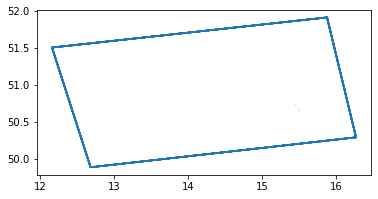

In [32]:

obs_list = [query_result[obs_key]['footprint'] for obs_key in query_result.keys()]
obs_gs = gpd.GeoSeries.from_wkt(obs_list)
#for obs_key in query_result.keys():
#    print(query_result[obs_key]['footprint'])
#    plt.plot(query_result[obs_key]['footprint'])
plt.figure()
ax = gdf.plot()
obs_gs.boundary.plot(ax=ax)
plt.show()